# Generate Data for EKF

In [450]:
from ekf import run_linear_ekf, LinearEkf, State
import numpy as np
import matplotlib.pyplot as plt

In [451]:
dt = 0.1
t_max = 500
t = np.arange(0, t_max, dt)
n = len(t)

# funny_term = np.array([(val-250)*(val-250) if val > 250 else 0 for val in t])

# x = 50 * np.sin(t/50*2*np.pi) + (t-5)*(t-2)*(t-7)*(t-14)*(t-20)*np.exp(-t/4) / 10 + funny_term
# x = np.array([val if abs(val) < 250 else 250 for val in x]).reshape((1,n))


# y = 50 * np.cos(t/50*2*np.pi) + (t-5)*(t-2)*(t-7)*(t-14)*(t-20)*np.exp(-t/5) / 10 + funny_term
# y = np.array([val if abs(val) < 250 else 250 for val in y]).reshape((1,n))
# x_true = np.vstack((x,y))



In [452]:

seed = 12324

def generate_car_data(t, 
                      pos_noise=3.0,     # meters
                      vel_noise=0.5,     # m/s
                      yaw_noise=0.02):   # rad
    """
    Generate smooth car trajectory + noisy observations for EKF testing.
    t : time array (seconds)
    """
    dt = np.diff(t, prepend=t[0])

    # True state arrays
    x = np.zeros_like(t)
    y = np.zeros_like(t)
    yaw = np.zeros_like(t)
    v = np.zeros_like(t)

    # Initial state
    x[0], y[0] = 0.0, 0.0
    yaw[0] = 0.0
    v[0] = 5.0  # m/s

    

    # Generate trajectory
    for i in range(1, len(t)):
        # Smooth acceleration + steering-like behavior
        a = 0.5*np.sin(0.2*t[i]) + np.random.normal(0, .3)  # randomish accel
        omega = 0.3*np.sin(0.1*t[i]) + np.random.normal(0, 2)   # smooth turning rate

        v[i] = v[i-1] + a * dt[i]
        yaw[i] = yaw[i-1] + omega * dt[i]
        x[i] = x[i-1] + v[i] * np.cos(yaw[i]) * dt[i]
        y[i] = y[i-1] + v[i] * np.sin(yaw[i]) * dt[i]

    # True states grouped
    true_state = np.vstack([x, y, yaw, v])

    # Noisy observations (modify as needed)
    z_pos = true_state[:2,:] + np.random.normal(0, pos_noise, (2, len(t)))
    z_vel = true_state[3,:] + np.random.normal(0, vel_noise, len(t))
    z_yaw = true_state[2,:] + np.random.normal(0, yaw_noise, len(t))

    obs = {
        "pos": z_pos,
        "vel": z_vel,
        "yaw": z_yaw
    }

    return true_state, obs

(2, 5000)


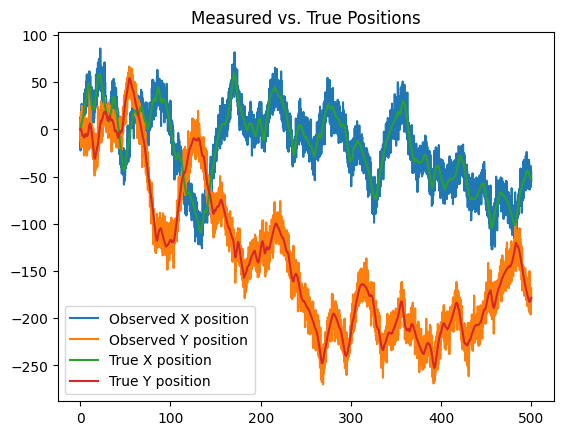

In [453]:
x_true, obs = generate_car_data(t, pos_noise=10)

print(obs["pos"].shape)
plt.title("Measured vs. True Positions")
plt.plot(t, obs["pos"][:2,:].T, label=("Observed X position","Observed Y position"))
plt.plot(t, x_true[:2,:].T, label=("True X position","True Y position"))
plt.legend()


# Linear Kalman Filter

In [454]:
# Simple 4d state (x, y, vx, vy)
# Measurement is (x, y)

# State
x0 = np.array([0,0,0,0])
P0 = np.diag(np.array([250, 250, 5, 5]))

# Model
F = np.array([
    [0,0,1,0],
    [0,0,0,1],
    [0,0,0,0],
    [0,0,0,0]
])
B = np.array([
    [0,0],
    [0,0],
    [1,0],
    [0,1]
]) # No input but still need something
H = np.array([
    [1,0,0,0],
    [0,1,0,0]
])

# Noise
Q = 20 * np.eye(4) 
R = 10 * np.eye(2) # Since 2 measurements

ekf = LinearEkf(F, B, H, Q, R)
state = State(x0, P0)


In [455]:
x_arr = np.zeros((4,n))
err = np.zeros((2,n))
# P_arr = np.zeros((n,4))

# no_input = np.zeros(1)
u = np.array([20, 20]).T


for i in range(n):
    
    # P_arr[i,:] = state.P
    z = x_true[:2,i] + np.random.normal(0, 1)
    # print(z)
    # print(z + np.random.normal(0, 1))
    # print()
    u_noise = np.array([200, 1]).T + np.random.normal(0, 1)
    state = run_linear_ekf(state, ekf, None, z)
    x_arr[:,i] = state.x
    err[:,i] = z - state.x[0:2]

(4, 5000)


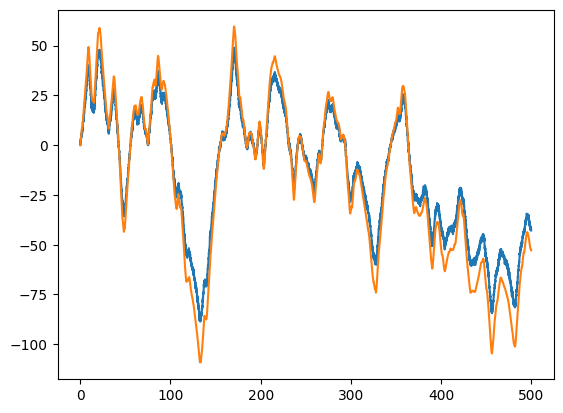

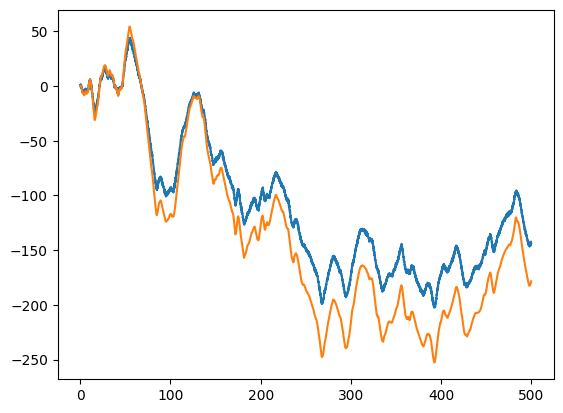

In [456]:
print(x_arr.shape)
start = 0
plt.plot(t[start:], x_arr[0,start:])
plt.plot(t[start:], x_true[0,start:])
plt.show()
plt.plot(t[start:], x_arr[1,start:])
plt.plot(t[start:], x_true[1,start:])
plt.show()

# plt.plot(t, true_state[0])
# plt.plot(t[4:], x_true[4:,0])
# print(x_arr[:4,0])
# plt.plot(t, x_true[:,0])
# plt.plot(t, err[:,0])
# plt.plot(x_arr[0,:])
# plt.ylim(350,400)

In [457]:
from ekf import run_nonlinear_ekf, NonlinearEkf, State
import numpy as np
import matplotlib.pyplot as plt